In [1]:
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model
import pygtc
import time

In [2]:
def build_partials(p,zs,unc,dpar,nmodes):
    '''
    p      = vector of cosmological parameters (npar x 1)
    zs     = tuple of redshifts of interest
    unc    = vector of uncertainties (n_kmodes x 1)
    dpar   = vector (you might want dif step sizes for dif params) of step sizes (npar x 1)
    nmodes = [scalar] number of modes in the spectrum - could be l-modes for CMB, k-modes for 21 cm, etc.
    '''
    nprm=len(p)
    V=np.zeros((nmodes,nprm))
    for par in range(nprm):
        V[:,par]=CAMBpartial(p,zs,par,dpar)
    return V

def fisher(partials,unc):
    '''
    partials = nmodes x nprm array where each column is an nmodes x 1 vector of the PS's partial WRT a dif param
    unc      = nmodes x 1 vector of standard deviations at each mode (could be k-mode, l-mode, etc.)
    '''
    nmodes,nprm=partials.shape
    V=np.zeros((nmodes,nprm))
    for i in range(nprm):
        V[:,i]=partials[:,i]/unc
    return V.T@V

scale=1e-9
def get_mps(pars,zs,kmax=2.0,linear=False,minkh=1e-4,maxkh=1,npts=200):
    '''
    get matter power spectrum 
    
    pars   = vector of cosmological parameters (npar x 1)
    zs     = redshifts of interest (**tuple** of floats)
    kmax   = max wavenumber to calculate the MPS for
    linear = if True, calc linear matter PS; else calc NL MPS (Boolean)
    minkh  = min value of k/h to calculate the MPS for
    maxkh  = max value of k/h to calculate the MPS for
    npts   = number of points in the calculated MPS
    '''
    zs=[zs]
    print('zs=',zs)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3] ######## find a way to bake into the MPS calc?
    As=pars[4]*scale ######## find a way to bake into the MPS calc?
    ns=pars[5]

    pars=camb.set_params(H0=H0, ombh2=ombh2, omch2=omch2, ns=ns, mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_matter_power(redshifts=zs, kmax=2.0)
    lin=True
    results = camb.get_results(pars)
    if lin:
        pars.NonLinear = model.NonLinear_none
    else:
        pars.NonLinear = model.NonLinear_both

    kh,z,pk=results.get_matter_power_spectrum(minkh=minkh,maxkh=maxkh,npoints=npts)
    return kh,pk

def CAMBpartial(p,zs,n,dpar):
    '''
    p    = vector of cosmological parameters (npar x 1)
    zs   = tuple of redshifts where we're interested in calculating the MPS
    n    = take the partial derivative WRT the nth parameter in p
    dpar = vector (you might want dif step sizes for dif params) of step sizes (npar x 1)
    '''
    nprm=len(p)
    kh,pk=get_mps(p,zs) # model should be get_spec for the unperturbed params
    npts=pk.shape[1]
    Ap=np.zeros([npts,1])
    pcopy=p.copy()
    pcopy[n]=pcopy[n]+dpar[n]
    khp,pkp=get_mps(pcopy,zs)
    fplus=np.array(pkp[:npts])
    pcopy=p.copy()
    pcopy[n]=pcopy[n]-dpar[n]
    khm,pkm=get_mps(pcopy,zs)
    fminu=np.array(pkm[:npts])
    return ((fplus-fminu)/(2*dpar[n])).reshape((npts,))

In [3]:
p0=np.asarray([67.7,0.022,0.119,0.056,2.1e-9, 0.97])
p0[4]/=scale
nprm=len(p0) # number of parameters
dpar=1e-3*np.ones(nprm)
dpar[4]*=scale
# ztest=tuple(np.arange(5,11))
# ztest=[3.7]
ztest=3.7
kh0,spec0=get_mps(p0,ztest,linear=True)

n_kmodes=len(spec0)
p0_tuple=tuple(p0) # tuple version to keep pyGTC happy

zs= [3.7]


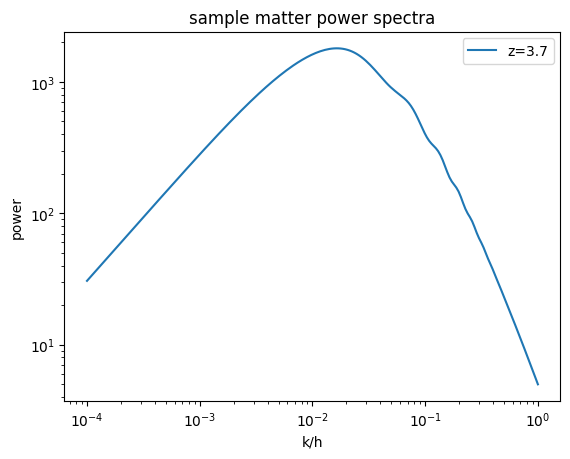

In [4]:
plt.figure()
if type(ztest)!=float:
    for zz in range(len(ztest)):
        plt.loglog(kh0,spec0[zz,:],label='z='+str(ztest[zz]))
else:
    plt.loglog(kh0,spec0[0,:],label='z='+str(ztest))
plt.xlabel('k/h')
plt.ylabel('power')
plt.title('sample matter power spectra')
plt.legend()
plt.show()

In [5]:
INITIAL=False

6 6


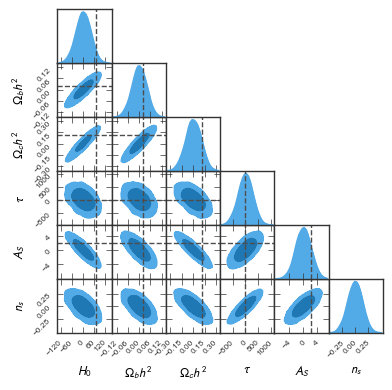

In [6]:
alpha=0.5
unc=alpha*spec0 # this says that the precision at each l-mode is alpha times the simulated spectrum value

if INITIAL:
    nmodes0=spec0.shape[1]
    t0=time.time()
    partials=build_partials(p0,ztest,unc,dpar,nmodes0)
    t1=time.time()
    print('calculating the PS partials took',t1-t0,'s')
    np.savetxt('camb_mps_partials_alpha.txt',partials)
else: 
    partials=np.genfromtxt('camb_mps_partials_alpha.txt')
fish=fisher(partials,unc)

pnames=['$H_0$','$\Omega_b h^2$','$\Omega_c h^2$','$\\tau$','$A_S$','$n_s$']
mean=np.zeros(nprm)
nsamp=10000
cov=np.linalg.inv(fish)
samps=np.random.multivariate_normal(mean,cov,size=nsamp)

print(len(p0_tuple),len(pnames))

GTC=pygtc.plotGTC(chains=samps,
                  paramNames=pnames,
#                   truths=p0,
                  truths=p0_tuple,
#                   truthLabels=pnames,
                  plotName='CAMB_matter_alpha.pdf')

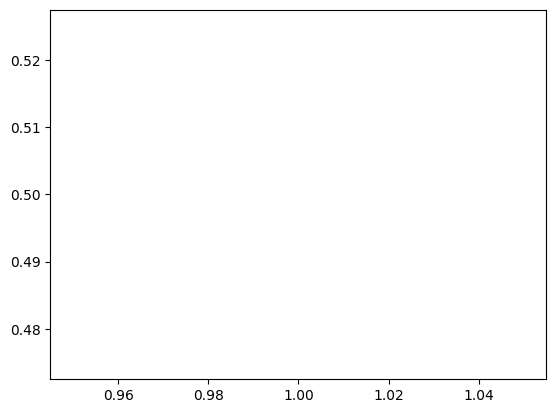

(10000, 6)


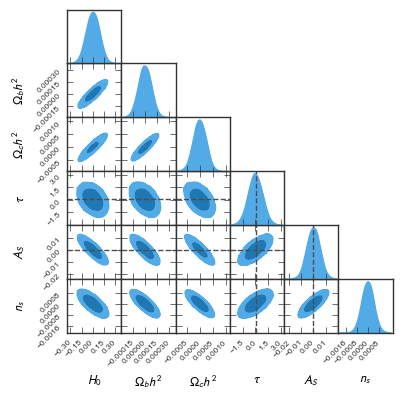

In [7]:
unc_x=np.arange(1,n_kmodes+1)
unc=(unc_x-n_kmodes/2)**2 # this says that the precision at each k-mode is alpha times the simulated spectrum value
unc/=(unc.max()/alpha)

if INITIAL:
    nmodes0=spec0.shape[1]
    t0=time.time()
    partials=build_partials(p0,ztest,unc,dpar,nmodes0)
    t1=time.time()
    print('calculating the PS partials took',t1-t0,'s')
    np.savetxt('camb_mps_partials_parab.txt',partials)
else: 
    partials=np.genfromtxt('camb_mps_partials_parab.txt')
fish=fisher(partials,unc)

plt.figure()
plt.plot(unc_x,unc)
plt.show()
fish=fisher(partials,unc)

pnames=['$H_0$','$\Omega_b h^2$','$\Omega_c h^2$','$\\tau$','$A_S$','$n_s$']
mean=np.zeros(nprm)
nsamp=10000
cov=np.linalg.inv(fish)
samps=np.random.multivariate_normal(mean,cov,size=nsamp)
print(samps.shape)
GTC=pygtc.plotGTC(chains=samps,
                  paramNames=pnames,
                  truths=(67.7,0.022,0.119,0.056,2.1e-9, 0.97),
#                   truths=p0,
#                   truths=p0_tuple,
                  plotName='CAMB_matter_parabola.pdf')

In [8]:
print(fish)

[[ 1.10388062e+06 -2.65887020e+08 -1.91887944e+08 -3.06976149e+04
   1.14740412e+07 -4.44692488e+07]
 [-2.65887020e+08  7.29222326e+10  3.99617135e+10  7.83931585e+06
  -2.91896061e+09  1.00008756e+10]
 [-1.91887944e+08  3.99617135e+10  3.90657828e+10  4.84680696e+06
  -1.83327028e+09  8.57389672e+09]
 [-3.06976149e+04  7.83931585e+06  4.84680696e+06  9.03104037e+02
  -3.34138795e+05  1.15275471e+06]
 [ 1.14740412e+07 -2.91896061e+09 -1.83327028e+09 -3.34138795e+05
   1.24224825e+08 -4.37688201e+08]
 [-4.44692488e+07  1.00008756e+10  8.57389672e+09  1.15275471e+06
  -4.37688201e+08  1.96496805e+09]]
